# CPVT Patients Demographics

- Clinical features
  - Heart structure abnormalities
  - Exercise induced PVT
  - Exercise induced syncope
  - Exercise induced sudden cardiac arrest
  - Abnormal ECG at rest
- Patient sex
- Inheritance pattern
- Family history of sudden cardiac death

In [55]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from analysis.database import get_config

sns.set_style("ticks")

In [56]:
config = get_config()

# create dir for figures
figures_dir = Path(
    os.path.join("..", "figures", config.version_for_dir, "analysis_08"))

if not os.path.exists(figures_dir):
    print(f"Creating directory: {figures_dir}")
    os.makedirs(figures_dir)

In [57]:
df = pd.read_excel(
    f"../data/individual_all_data-{config.version}.xlsx",
    index_col=0,
)
df.head()

,individual_id,sex,publication_id,title,first_author,reference,doi,year,publication_database,resource_uri,...,treatment_taken::Implantable cardioverter-defibrillator,treatment_taken::Left cardiac sympathetic denervation,treatment_taken::Verapamil,effective::Beta blocker,effective::Catheter ablation,effective::Enalapril,effective::Flecainide,effective::Implantable cardioverter-defibrillator,effective::Left cardiac sympathetic denervation,effective::Verapamil
0,1,NaN,1,Familial Evaluation in Catecholaminergic Polym...,Van Der Werf C,NaN,10.1161/CIRCEP.112.970517,2012,PubMed,https://pubmed.ncbi.nlm.nih.gov/22787013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,female,2,Flecainide therapy reduces exercise-induced ve...,"van der Werf, C",NaN,10.1016/j.jacc.2011.01.026,2011,PubMed,https://pubmed.ncbi.nlm.nih.gov/21616285,...,0.0,0.0,0.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN
2,3,male,3,Structural abnormalities on cardiac magnetic r...,"Gerber, D",NaN,10.1016/j.jacep.2020.03.006,2020,PubMed,https://pubmed.ncbi.nlm.nih.gov/32553227,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,female,4,Genetic Background of Catecholaminergic Polymo...,"Kawamura, M",NaN,10.1253/circj.cj-12-1460,2013,PubMed,https://pubmed.ncbi.nlm.nih.gov/23595086,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,male,5,Gender differences in the inheritance mode of ...,"Ohno, S.",NaN,10.1371/journal.pone.0131517,2015,PubMed,https://pubmed.ncbi.nlm.nih.gov/26114861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_cpvt = df[
    df["Catecholaminergic polymorphic ventricular tachycardia 1"] == 1
    ]
# use this for individual data to prevent duplicates
df_cpvt_individuals = df_cpvt.drop_duplicates(subset="individual_id")
print(f"Number of CPVT patients: {df_cpvt_individuals.shape[0]}")

Number of CPVT patients: 964


In [59]:
# number of unique variants (that can be parsed and are not impossible to parse bc the researchers wrote exon 3 instead of the HGVS notation)
df_cpvt["sequence_variant_id"].nunique()
# number of protein HGVS strings (should be less since cdna will sometimes map to same amino acid)
df_cpvt["p_hgvs_string"].nunique()

272

In [60]:
def add_bar_labels(ax, fmt="{:.0f}", ignore_zero=True, direction="vertical"):
    for bar in ax.patches:

        if bar.get_height() == 0 and ignore_zero:
            continue

        if direction == "vertical":
            # Use ax.text() to add text over the bars
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                    fmt.format(bar.get_height()),
                    ha='center', va='bottom')
            # add 1% to the height
            y_min, y_max = ax.get_ylim()
            ax.set_ylim(y_min, (y_max - y_min) * 0.01 + y_max)
        else:
            ax.text(bar.get_width() + 0.02 * bar.get_width(),
                    bar.get_y() + bar.get_height() / 2,
                    fmt.format(bar.get_width()),
                    ha='left', va='center')
            # add 1% to the width
            x_min, x_max = ax.get_xlim()
            ax.set_xlim(x_min, (x_max - x_min) * 0.01 + x_max)

    sns.despine()


def save_current_plot(name: str):
    for fmt in ["png", "pdf", "svg"]:
        plt.savefig(
            os.path.join(figures_dir / f"{name}.{fmt}"), dpi=300)


from typing import Literal

TINY_GRAPH_SIZE = (2.125, 2.75)
TINY_GRAPH_FONT_LABEL = 8
TINY_GRAPH_TITLE = 10
TINY_GRAPH_TICK_LABEL = 8


def set_graph_sizes(
        axis_,
        *,
        x_label: str = None,
        x_size: int = None,
        y_label: str = None,
        y_size: int = None,
        title_: str = None,
        title_size: int = None,
        title_loc: Literal["left", "center", "right"] = "center",
        tick_size: int = None,
        x_tick_rotation: int = None,
        x_tick_ha: Literal["left", "center", "right"] = "center"
):
    if x_label is not None:
        plt.xlabel(x_label,
                   fontsize=x_size if x_size else TINY_GRAPH_FONT_LABEL)
    if y_label is not None:
        plt.ylabel(y_label,
                   fontsize=y_size if y_size else TINY_GRAPH_FONT_LABEL)
    if title_ is not None:
        plt.title(title_,
                  fontsize=title_size if title_size else TINY_GRAPH_TITLE,
                  loc=title_loc)

    plt.xticks(fontsize=tick_size if tick_size else TINY_GRAPH_TICK_LABEL,
               rotation=x_tick_rotation if x_tick_rotation else 0,
               ha=x_tick_ha
               )
    plt.yticks(fontsize=tick_size if tick_size else TINY_GRAPH_TICK_LABEL)

    axis_.bar_label(ax.containers[0], fontsize=10)
    axis_.bar_label(ax.containers[1], fontsize=10)

    sns.despine()

## Clinical features


In [61]:
df_cpvt_individuals["Heart Structure Abnormality"].value_counts()

Heart Structure Abnormality
0.0    447
1.0     44
Name: count, dtype: int64

Total patients: 321


,Exercise/stress induced polymorphic ventricular tachycardia,count,percentage
0,True,315,98.13
1,False,6,1.87


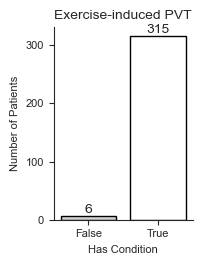

Total patients: 270


,Syncope exercise/stress induced,count,percentage
0,True,261,96.67
1,False,9,3.33


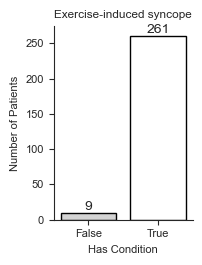

Total patients: 113


,Exercise/stress induced sudden cardiac arrest,count,percentage
0,True,97,85.84
1,False,16,14.16


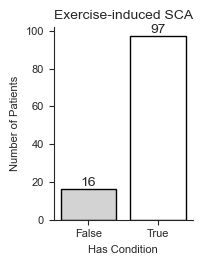

Total patients: 463


,Baseline/resting electrocardiogram abnormality,count,percentage
0,False,387,83.59
1,True,76,16.41


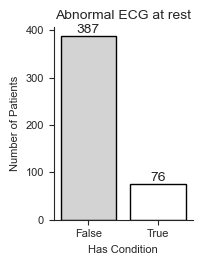

Total patients: 491


,Heart Structure Abnormality,count,percentage
0,False,447,91.04
1,True,44,8.96


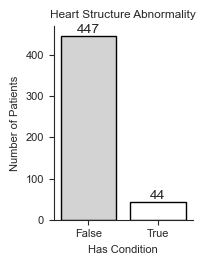

In [62]:
conditions_to_graph = {
    "Exercise/stress induced polymorphic ventricular tachycardia": "Exercise-induced PVT",
    "Syncope exercise/stress induced": "Exercise-induced syncope",
    "Exercise/stress induced sudden cardiac arrest": "Exercise-induced SCA",
    "Baseline/resting electrocardiogram abnormality": "Abnormal ECG at rest",
    "Heart Structure Abnormality": "Heart Structure Abnormality",
}

for condition, title in conditions_to_graph.items():
    condition_data = df_cpvt_individuals[condition].value_counts().reset_index()
    condition_data[condition] = condition_data[condition].apply(
        lambda x: bool(x))

    total_patients = condition_data["count"].sum()

    print(f"Total patients: {total_patients}")

    condition_data["percentage"] = condition_data["count"].apply(
        lambda x: x / total_patients * 100).round(2)

    display(condition_data)

    plt.figure(figsize=TINY_GRAPH_SIZE)
    ax = sns.barplot(
        data=condition_data,
        x=condition,
        y="count",
        hue=condition,
        legend=False,
        edgecolor="black",
        palette=["lightgray" if i % 2 == 0 else "white" for i in range(2)]
    )

    set_graph_sizes(
        ax,
        x_label="Has Condition",
        y_label="Number of Patients",
        title_=title,
        title_size=TINY_GRAPH_TITLE if len(title) < 21 else 8.5,
    )

    plt.tight_layout()

    save_current_plot(title)

    plt.show()

## Sex

In [63]:
patient_sex = pd.DataFrame(df_cpvt_individuals["sex"].value_counts())
patient_sex["percentage"] = (
        patient_sex["count"] / patient_sex["count"].sum() * 100).round(2)
patient_sex

,count,percentage
sex,,
female,463,56.88
male,351,43.12


In [64]:
df_cpvt_individuals["sex"].value_counts(dropna=False)

sex
female    463
male      351
NaN       150
Name: count, dtype: int64

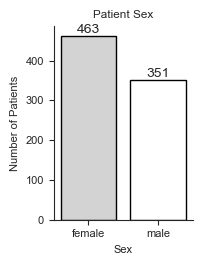

In [73]:
plt.figure(figsize=TINY_GRAPH_SIZE)
ax = sns.barplot(
    data=patient_sex,
    x="sex",
    y="count",
    hue="sex",
    legend=False,
    edgecolor="black",
    palette=["lightgray" if i % 2 == 0 else "white" for i in range(2)]
)

set_graph_sizes(
    ax,
    x_label="Sex",
    y_label="Number of Patients",
    title_="Patient Sex",
    title_size=TINY_GRAPH_TITLE if len(title) < 21 else 8.5,
)

plt.tight_layout()

save_current_plot("sex_of_patients")

plt.show()

## Inheritance pattern

In [66]:
variant_inherit = pd.DataFrame(df_cpvt["inheritance"].value_counts())
variant_inherit["percentage"] = (
        variant_inherit["count"] / variant_inherit["count"].sum() * 100).round(
    2)
variant_inherit

,count,percentage
inheritance,,
inherited,186,68.13
spontaneous,87,31.87


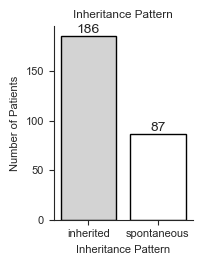

In [72]:
plt.figure(figsize=TINY_GRAPH_SIZE)
ax = sns.barplot(
    data=variant_inherit,
    x="inheritance",
    y="count",
    hue="inheritance",
    legend=False,
    edgecolor="black",
    palette=["lightgray" if i % 2 == 0 else "white" for i in range(2)]
)

set_graph_sizes(
    ax,
    x_label="Inheritance Pattern",
    y_label="Number of Patients",
    title_="Inheritance Pattern",
    title_size=TINY_GRAPH_TITLE if len(title) < 21 else 8.5,
)

plt.tight_layout()

save_current_plot("inheritance_pattern")

plt.show()

## Family history of sudden cardiac death

In [68]:
bool(np.nan)

True

In [69]:
df_scd = df_cpvt_individuals[[
    "individual_id",
    "Sudden cardiac death::Mother",
    "Sudden cardiac death::Father",
    "Sudden cardiac death::num_family_members",
]].copy()
family_scd_col = "Family History of SCD"


def has_scd(row):
    if pd.isna(row["Sudden cardiac death::Mother"]) and pd.isna(
            row["Sudden cardiac death::Father"]) and pd.isna(
        row["Sudden cardiac death::num_family_members"]):
        return np.nan

    mother = row["Sudden cardiac death::Mother"] == 1
    father = row["Sudden cardiac death::Father"] == 1
    num_family_members = row["Sudden cardiac death::num_family_members"] > 0

    return mother or father or num_family_members


df_scd[family_scd_col] = df_scd.apply(
    has_scd,
    axis=1
)
df_scd.head()

,individual_id,Sudden cardiac death::Mother,Sudden cardiac death::Father,Sudden cardiac death::num_family_members,Family History of SCD
0,1,1.0,0.0,NaN,True
1,2,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN
3,4,NaN,NaN,0.0,False
4,5,NaN,NaN,NaN,NaN


In [70]:
family_scd = pd.DataFrame(df_scd[family_scd_col].value_counts())
family_scd["percentage"] = (
        family_scd["count"] / family_scd[
    "count"].sum() * 100).round(2)
family_scd

,count,percentage
Family History of SCD,,
True,349,70.93
False,143,29.07


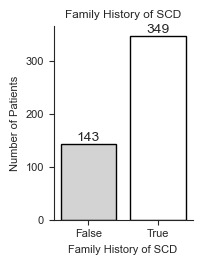

In [71]:
plt.figure(figsize=TINY_GRAPH_SIZE)
sns.set_style("ticks")
ax = sns.barplot(
    data=family_scd,
    x="Family History of SCD",
    y="count",
    hue="Family History of SCD",
    legend=False,
    edgecolor="black",
    palette=["lightgray" if i % 2 == 0 else "white" for i in range(2)]
)

set_graph_sizes(
    ax,
    x_label="Family History of SCD",
    y_label="Number of Patients",
    title_="Family History of SCD",
    title_size=TINY_GRAPH_TITLE if len(title) < 21 else 8.5,
)

plt.tight_layout()

save_current_plot("family_history_scd")

plt.show()